# Interpret Candidates

Take candidates from EnhDesign notebook, marginalize over different background with held-out model folds and rank them.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm
from matplotlib.patches import Rectangle
import pyBigWig

import sys
sys.path.append("/users/surag/kundajelab/retina-models/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data, get_seq, get_cts
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

from metrics import softmax 
import scipy.stats
import joblib

In [249]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def get_profile(output):
    prof, cts = output
    return softmax(prof)*(np.exp(cts)-1)

## Load Models

In [4]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [6]:
models = defaultdict(dict)
ctypes = []
FOLDS = 5

with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    for x in glob.glob("/oak/stanford/groups/akundaje/surag/projects/retina_Howard/models/20220202_bpnet/fold0/saved/*.h5"):
        ctype = x.split("/")[-1].split(".")[0]
        ctypes.append(ctype)
        print(ctype)
        
        for i in range(FOLDS):
            models[ctype][i] = tf.keras.models.load_model(x.replace("fold0", "fold" + str(i)))

Astrocyte


2024-11-06 07:48:40.298180: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 07:48:44.611637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0


Microglia
AIIamacrine
GABAamacrine
Glyamacrine
Rodbipolar
ONconebipolar
OFFconebipolar
Horizontal
Mullerglia
Rod
Cone
Retinalganglioncell


In [7]:
len(ctypes)

13

In [8]:
model_count_explainers = defaultdict(dict)

# explainers
for x in ctypes:
    for i in range(FOLDS):
        model_count_explainers[x][i] = shap.explainers.deep.TFDeepExplainer(
                (models[x][i].input,
                 tf.reduce_sum(models[x][i].outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [9]:
INP_LEN = models[ctypes[0]][0].input_shape[1]
OUT_LEN = models[ctypes[0]][0].output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

### Load predictions over peak

To map to quantile per model.

In [10]:
peak_preds = joblib.load("../notebooks/out/peak_preds.joblib")

In [11]:
peak_preds.keys()

dict_keys(['Rod', 'OFFconebipolar', 'Retinalganglioncell', 'Horizontal', 'AIIamacrine', 'Microglia', 'Glyamacrine', 'Mullerglia', 'GABAamacrine', 'ONconebipolar', 'Astrocyte', 'Cone', 'Rodbipolar'])

## Marginalize

### Prepare background sequences to marginalize over

In [260]:
TARGET = "Horizontal"

In [261]:
bg_set = pd.read_csv("/mnt/lab_data3/surag/kundajelab/retina-design/data/filtered_negatives/{}_peakCalls_sorted.gc.neg.bed.filt.neg.bed".format(TARGET),
                         sep='\t', names=['chr','start','end','1','2','3','4','5','6','summit']).sample(100)

bg_set.head()

,chr,start,end,1,2,3,4,5,6,summit
88892,chr22,40839000,40842000,.,.,.,.,.,.,1500
5890,chr1,237597000,237600000,.,.,.,.,.,.,1500
60305,chr12,7797000,7800000,.,.,.,.,.,.,1500
55706,chr11,40353000,40356000,.,.,.,.,.,.,1500
23086,chr4,137490000,137493000,.,.,.,.,.,.,1500


In [226]:
IDX=0
bg_seqs = one_hot.dna_to_one_hot([str(hg38[bg_set.iloc[i]['chr']][bg_set.iloc[i]['start'] + bg_set.iloc[i]['summit'] - INP_LEN//2:bg_set.iloc[i]['start'] + bg_set.iloc[i]['summit'] + INP_LEN//2]) \
                                   for i in range(len(bg_set))])

In [227]:
bg_seqs.shape

(100, 2114, 4)

In [228]:
bg_preds_quants = {}

for m in models:
    for fold in PRED_FOLDS:
        bg_preds_quants[f"{m}_fold_{fold}"] = np.mean([np.mean(peak_preds[m] < x) for x in models[m][fold].predict(bg_seqs)[1]])

In [229]:
pd.DataFrame({k:[v] for k,v in bg_preds_quants.items()}).to_csv(f"./out/{TARGET}_bg_avg_scores_fold_3_4.tsv", sep='\t', index=None)

### Predict

Load candidates.

In [265]:
candidates = joblib.load("../notebooks/out/v1/{}_candidates.joblib".format(TARGET))
candidates.shape

(100, 320, 4)

In [266]:
PRED_FOLDS = [3,4]

In [159]:
preds = defaultdict(lambda : defaultdict(dict))

In [ ]:
for idx, cand in enumerate(tqdm(candidates)):
    seqs_w_cand = bg_seqs.copy()
    seqs_w_cand[:, INP_LEN//2 - candidates.shape[1]//2:INP_LEN//2 + candidates.shape[1]//2] = cand
    
    for m in models:
        for fold in PRED_FOLDS:
            preds[idx][m][fold] = models[m][fold].predict(seqs_w_cand)

 46%|███████████████████████████████████████████████████████▏                                                                | 46/100 [06:29<07:34,  8.42s/it]

In [162]:
preds_quants = defaultdict(lambda : defaultdict(dict))
for idx in range(len(candidates)):
    for m in models:
        for fold in PRED_FOLDS:
            preds_quants[idx][m][fold] = np.mean([np.mean(peak_preds[m] < x) for x in preds[idx][m][fold][1]])

In [163]:
np.mean(list(preds_quants[0]['Rod'].values()))

0.06537

In [164]:
preds_quants_fold_avg = defaultdict(lambda : dict())
for idx in range(len(candidates)):
    for m in models:
        preds_quants_fold_avg[idx][m] = np.mean(list(preds_quants[idx][m].values()))

In [165]:
gaps = [(i, preds_quants_fold_avg[i][TARGET] - max([v for k,v in preds_quants_fold_avg[i].items() if k!=TARGET])) \
            for i in range(len(candidates))]

In [166]:
sorted(gaps, key=lambda x:-x[1])

[(72, 0.8787665),
 (36, 0.874459),
 (94, 0.8726229999999999),
 (28, 0.8646099999999999),
 (4, 0.8598250000000001),
 (66, 0.856951),
 (73, 0.8538029999999999),
 (63, 0.8523270000000001),
 (31, 0.8513355),
 (53, 0.8479964999999999),
 (57, 0.8402319999999999),
 (54, 0.8377595),
 (46, 0.8376799999999999),
 (42, 0.8340375000000001),
 (95, 0.8329060000000001),
 (71, 0.8327249999999999),
 (43, 0.8310255000000002),
 (5, 0.8256530000000001),
 (45, 0.8256525),
 (41, 0.817609),
 (48, 0.8174779999999999),
 (8, 0.8173945),
 (93, 0.8171055),
 (11, 0.8147345000000001),
 (13, 0.810777),
 (70, 0.8080004999999999),
 (98, 0.8045375000000001),
 (7, 0.8014475),
 (59, 0.8003604999999998),
 (17, 0.7989085),
 (69, 0.7957015000000001),
 (67, 0.7945939999999999),
 (84, 0.791822),
 (80, 0.7912204999999998),
 (27, 0.7886504999999999),
 (52, 0.7885449999999999),
 (21, 0.7877325000000002),
 (86, 0.785429),
 (88, 0.7841285),
 (3, 0.7819865),
 (83, 0.7809835),
 (32, 0.7806354999999999),
 (33, 0.7805504999999999),
 (75, 0.7782899999999999),
 (92, 0.777726),
 (39, 0.777317),
 (20, 0.7753124999999998),
 (50, 0.7726075000000001),
 (15, 0.7687035),
 (51, 0.7666325),
 (30, 0.7605255),
 (89, 0.7602725),
 (87, 0.7458915),
 (61, 0.7409229999999999),
 (74, 0.7407320000000002),
 (47, 0.7406619999999999),
 (14, 0.7405394999999999),
 (76, 0.7358360000000002),
 (96, 0.7346284999999999),
 (37, 0.7341945000000001),
 (78, 0.7298209999999999),
 (64, 0.7277169999999998),
 (65, 0.72572),
 (79, 0.7236334999999999),
 (91, 0.7227175000000001),
 (90, 0.7159975000000001),
 (25, 0.715617),
 (26, 0.7112544999999999),
 (62, 0.710551),
 (1, 0.7095635000000002),
 (23, 0.70862),
 (10, 0.7069595),
 (24, 0.7059109999999998),
 (40, 0.7048879999999997),
 (12, 0.6972845),
 (77, 0.6959145),
 (2, 0.6838045000000001),
 (16, 0.683587),
 (6, 0.6833230000000001),
 (19, 0.680005),
 (9, 0.6763250000000002),
 (60, 0.6760090000000001),
 (34, 0.6725030000000002),
 (49, 0.6691204999999999),
 (18, 0.65666),
 (55, 0.6394795000000001),
 (58, 0.6183969999999999),
 (22, 0.6155284999999999),
 (97, 0.5938165),
 (35, 0.584625),
 (29, 0.5684555000000001),
 (44, 0.4642160000000001),
 (56, 0.430392),
 (99, 0.18842050000000005),
 (81, -0.0314985),
 (85, -0.0685085),
 (68, -0.0877125),
 (0, -0.09401900000000002),
 (82, -0.10569600000000001),
 (38, -0.18749300000000002)]

In [167]:
preds_quants_fold_avg[36]

{'Astrocyte': 0.0268245,
 'Microglia': 0.071162,
 'AIIamacrine': 0.07134850000000001,
 'GABAamacrine': 0.06800750000000001,
 'Glyamacrine': 0.050764500000000004,
 'Rodbipolar': 0.0508935,
 'ONconebipolar': 0.025493000000000002,
 'OFFconebipolar': 0.041373999999999994,
 'Horizontal': 0.961816,
 'Mullerglia': 0.049875,
 'Rod': 0.08735700000000002,
 'Cone': 0.026624999999999996,
 'Retinalganglioncell': 0.026959999999999998}

In [ ]:
# selected Retinalganglion idx: 14, 68, 86
# selected Horizontal idx: 36, 72, 73

In [168]:
one_hot.one_hot_to_dna(candidates)[72]

'TAGATGAGGTTGTGAAGGTGCAGACAGCTAGGCTCCTGGTGCACACTGTGTTCTTATTAAACACTATGGTCACAGTTGTCTATTGATTTGGATCCTATTGATTTCCTGCCATTGGCCTCCTCTCTGCACTGCTGCTGCCTGAGGGCAACTCTATTGATTTTCACTCCCCACTCTGATATTGATTTCTTGCAGAGCTGTGTTCTCTGACCCCCTCCTCCTTTCCAGTCCTGCCCTTCCACTCCCTCCGGAGTCATCCTGTGAGGGCTCACAATGGCCTTTTACTTCTCCCCACACAATGAACATGCTGGGAACTTCCACCA'

In [169]:
one_hot.one_hot_to_dna(candidates)[36]

'AGAGAGAATGAGAGAAATCAATAAGCAGAAAAAATCAATAAAACCATCAGATTGCCCCCAGGCAAATGACTGCCATGAGAACAGAAAAATCAATAGAAAACCATCGACAGCCTGGCTGCATCTCCCACTGGGTCCCTCCCACAATACATGGGAATTATGGGAACTACAATTCAAGGTGAGATTTGGGTGGGGACACAGGCAAACCATATCAAGACCCAAGGCTGTATGTTCAGAGCGAGGTGTGCCAAGCCCTGGGAGACCCACAGCTACCCATCATCGAGGTGCTTCAATGCATGGGTTCAGAGCCTCCTGTCTCCACC'

In [269]:
one_hot.one_hot_to_dna(candidates)[73]

'AGTAATCATCCATTGTATGGATATACCACATTTTGTTTATCTATACAACTGTCAATGGACCCTGGGTTGCTTCCACCTTTTGGCTACTGTGAATAAGATGCTGTGAACATGGGTGTACAACGTCTGTTTTGAGTCTTTGCTTTCACTTCTCTGAGTTTATACCTAGAAGTGAAATTGATAGATCAGCCTGGCTGCCTATGTTTAATTAGTTTTTGTTGCCCTCAGGCAGAGTCTCACTATTGATTTCAGGCTTGAGTGCACTTATTGATTTTTGGCTCACTAAATCAATAGCTTCCCGGGTTCAATCAATTCTCTTGCCT'

['seq',
 'Astrocyte',
 'Microglia',
 'AIIamacrine',
 'GABAamacrine',
 'Glyamacrine',
 'Rodbipolar',
 'ONconebipolar',
 'OFFconebipolar',
 'Horizontal',
 'Mullerglia',
 'Rod',
 'Cone',
 'Retinalganglioncell']

In [149]:
preds_quants_df = OrderedDict({'seq':one_hot.one_hot_to_dna(candidates)})

selected = [False]*len(candidates)

selected[14] = True
selected[86] = True
selected[68] = True

preds_quants_df['selected'] = selected

for fold in PRED_FOLDS:
    for m in models:
        preds_quants_df[f"{m}_fold_{fold}"] = [preds_quants[i][m][fold] for i in range(len(preds_quants))]

preds_quants_df = pd.DataFrame(preds_quants_df)

In [150]:
preds_quants_df.head()

,seq,selected,Astrocyte_fold_3,Microglia_fold_3,AIIamacrine_fold_3,GABAamacrine_fold_3,Glyamacrine_fold_3,Rodbipolar_fold_3,ONconebipolar_fold_3,OFFconebipolar_fold_3,...,GABAamacrine_fold_4,Glyamacrine_fold_4,Rodbipolar_fold_4,ONconebipolar_fold_4,OFFconebipolar_fold_4,Horizontal_fold_4,Mullerglia_fold_4,Rod_fold_4,Cone_fold_4,Retinalganglioncell_fold_4
0,GGCGGCCGGGCAGATGTGCTCGTCACTTCCCAGATGGAATAAATAA...,False,0.062964,0.147173,0.496245,0.584388,0.540943,0.129788,0.247518,0.267468,...,0.867723,0.329098,0.467229,0.335916,0.128178,0.088362,0.302848,0.154760,0.117857,0.883785
1,ATGGGCATGTCAGTAAATATGGAGAGGAGGAACCACATAAGCAAAG...,False,0.041247,0.058697,0.086111,0.338867,0.080970,0.042946,0.053009,0.041376,...,0.413153,0.062787,0.077187,0.034467,0.063616,0.052969,0.092220,0.105919,0.032115,0.850891
2,AAGGTGAGTCTCTCATCAATTATTTATTTGGAGTGCAGTGGCACAA...,False,0.046065,0.057596,0.109493,0.234598,0.124295,0.071669,0.064576,0.075445,...,0.303157,0.090440,0.107476,0.070410,0.161603,0.197923,0.104453,0.121096,0.046394,0.909602
3,CCCATCAAAAAGCGTGGTGCGGCTCTGGACCCACTGAATTATTTAT...,False,0.054907,0.067687,0.097495,0.076811,0.108806,0.065097,0.063741,0.053261,...,0.124306,0.065521,0.083835,0.047104,0.136004,0.096321,0.114417,0.106823,0.043383,0.882810
4,GCGGCTCCGCACGATGGCTGGGGACATTCATGTATTATTTATCAAG...,False,0.060132,0.077659,0.188356,0.154748,0.112876,0.051166,0.080741,0.074539,...,0.209519,0.116605,0.099840,0.067983,0.128880,0.091409,0.145393,0.143334,0.050773,0.933220


In [151]:
preds_quants_df[preds_quants_df['selected']]

,seq,selected,Astrocyte_fold_3,Microglia_fold_3,AIIamacrine_fold_3,GABAamacrine_fold_3,Glyamacrine_fold_3,Rodbipolar_fold_3,ONconebipolar_fold_3,OFFconebipolar_fold_3,...,GABAamacrine_fold_4,Glyamacrine_fold_4,Rodbipolar_fold_4,ONconebipolar_fold_4,OFFconebipolar_fold_4,Horizontal_fold_4,Mullerglia_fold_4,Rod_fold_4,Cone_fold_4,Retinalganglioncell_fold_4
14,CAGTCCCAATGCGAGTCCCTGGATATTTCAGTTGAAGGTGCTGTAT...,True,0.043826,0.055836,0.072887,0.068524,0.080098,0.039315,0.053762,0.031509,...,0.103362,0.057623,0.061123,0.025448,0.063102,0.073987,0.098479,0.105511,0.037414,0.889384
68,GATCCAGTGAATGAAACCGGGACAGCCTCATGAATTATTTATCCAG...,True,0.051344,0.063453,0.101393,0.116646,0.098479,0.061576,0.065591,0.065021,...,0.164701,0.070180,0.085346,0.058357,0.162892,0.139749,0.107475,0.105559,0.044304,0.925809
86,GCTTGCAGTGAGCAGAGATTTCATGAATTATTTATCATGAGGGCCG...,True,0.050148,0.072415,0.116820,0.140723,0.104756,0.071526,0.079560,0.072557,...,0.168129,0.098655,0.122525,0.065063,0.191277,0.147097,0.124401,0.118930,0.048906,0.922128


In [152]:
preds_quants_df.to_csv("./out/Retinalganglioncell_candidates_scores_fold_3_4.tsv", sep='\t', index=False)

## Viz Importance

In [262]:
imp_quantiles_low = {}
imp_quantiles_high = {}

for m in models:
    with open(f"/oak/stanford/groups/akundaje/surag/projects/retina_Howard/models/20220202_bpnet/fold0/interpret_bigwigs/{m}.counts.importance.stats.txt", "r") as f:
        d = [x.strip() for x in f]
        
    imp_quantiles_low[m] = float(d[1].split('\t')[1])
    imp_quantiles_high[m] = float(d[7].split('\t')[1])

In [283]:
imp_quantiles_high

{'Astrocyte': 0.070498,
 'Microglia': 0.082066,
 'AIIamacrine': 0.080046,
 'GABAamacrine': 0.091997,
 'Glyamacrine': 0.084268,
 'Rodbipolar': 0.104894,
 'ONconebipolar': 0.102988,
 'OFFconebipolar': 0.104597,
 'Horizontal': 0.063544,
 'Mullerglia': 0.103798,
 'Rod': 0.133673,
 'Cone': 0.104068,
 'Retinalganglioncell': 0.071821}

In [289]:
IDX = 73

In [290]:
cur_raw_seqs = np.expand_dims(bg_seqs[0].copy(), 0)
cur_raw_seqs[:, INP_LEN//2 - candidates[IDX].shape[0]//2:INP_LEN//2 + candidates[IDX].shape[0]//2] = candidates[IDX]

# counts_shap_scores = np.array([model_count_explainers[CTYPE1][i].shap_values(cur_raw_seqs) for i in range(FOLDS)]).mean(0)
# projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores)

# FOLD=4

proj_scores = {}
for m in models:
    counts_shap = np.vstack([model_count_explainers[m][fold].shap_values(cur_raw_seqs) for fold in PRED_FOLDS]).mean(0, keepdims=True)
    proj_scores[m] = np.multiply(cur_raw_seqs, counts_shap)

In [291]:
proj_scores[m].shape

(1, 2114, 4)

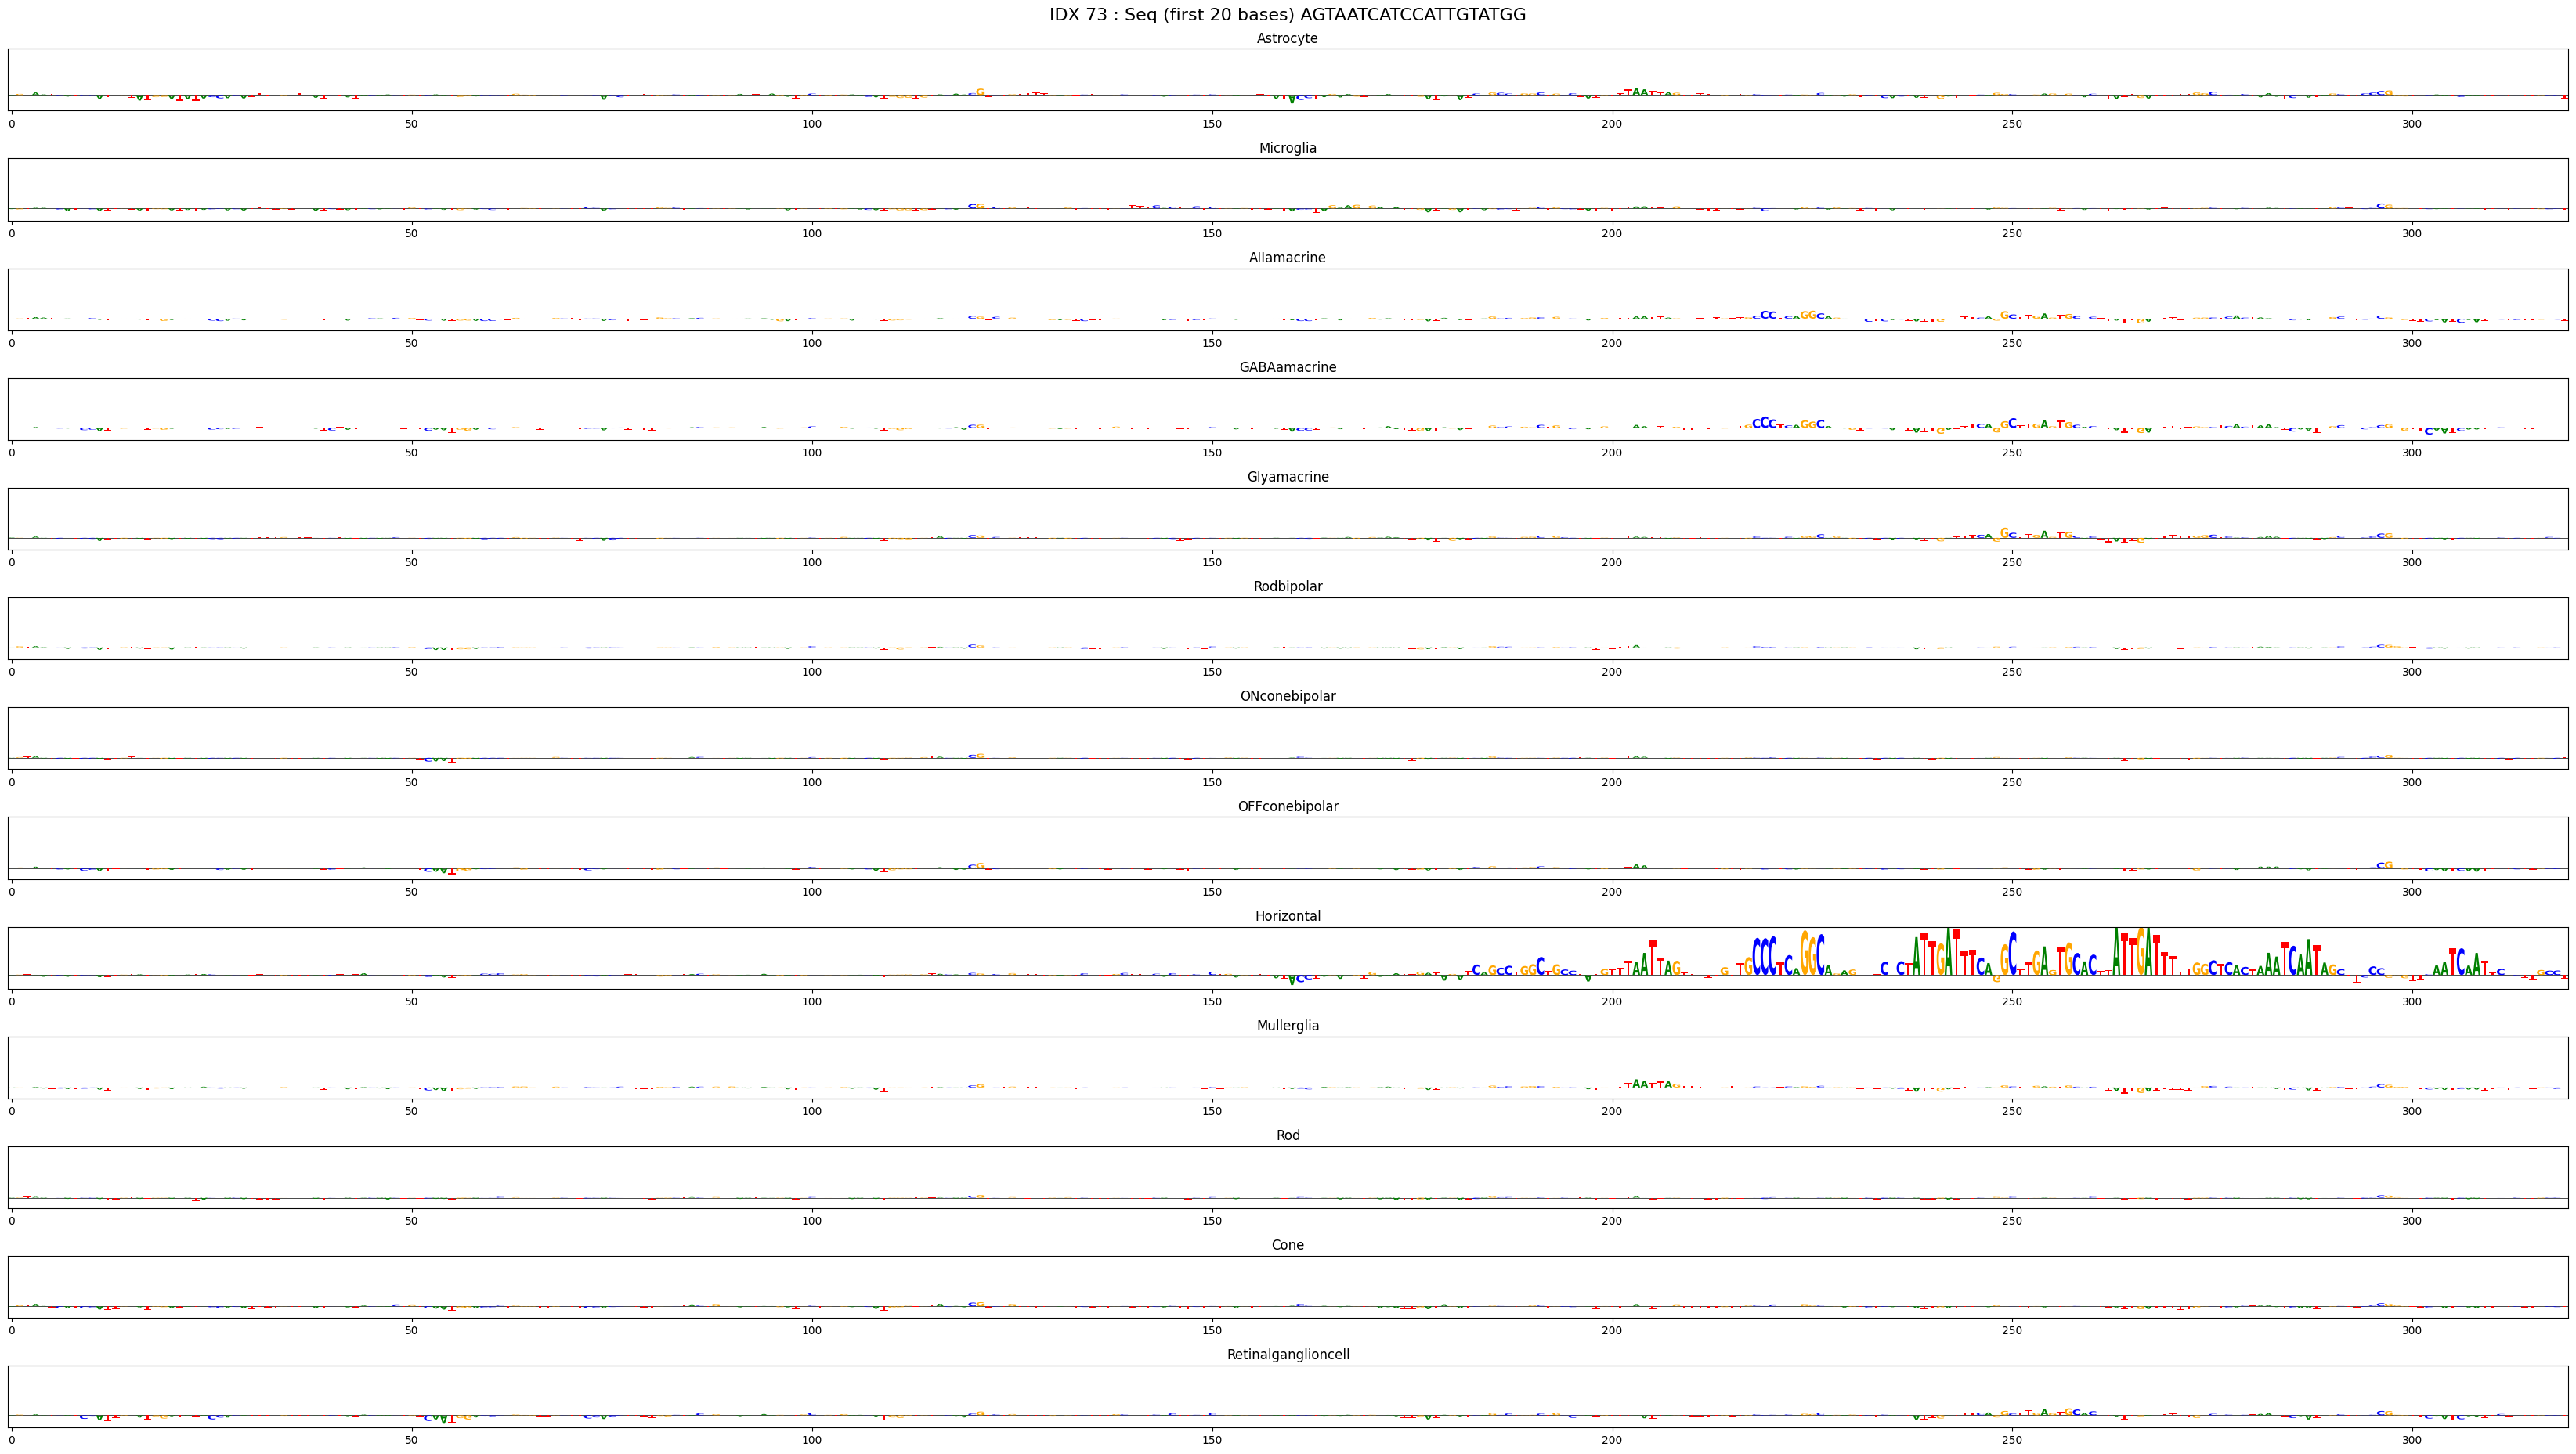

In [292]:
WINDOW = 320
SLICE_START = INP_LEN//2 - WINDOW//2
SLICE_END = INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(len(models), figsize=(WINDOW/10 + 1,1.5*len(models)))

for i,m in enumerate(models):
    cur_scores = proj_scores[m][0][SLICE_START:SLICE_END]
    cur_scores[cur_scores > imp_quantiles_high[m]+.01] = imp_quantiles_high[m]+.01
    logomaker.Logo(pd.DataFrame(cur_scores, columns=['A','C','G','T']),
                  ax=ax[i])
    ax[i].title.set_text(m)
    ax[i].set_ylim((imp_quantiles_low[m]-.01, imp_quantiles_high[m]+.01))
    ax[i].tick_params(axis='y', left=False, labelleft=False)

short_seq = one_hot.one_hot_to_dna(candidates[IDX:IDX+1])[0][:20]

fig.suptitle(f"IDX {IDX} : Seq (first 20 bases) {short_seq}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

plt.savefig(f"./figs/{TARGET}_IDX_{IDX}_({short_seq}).pdf")
plt.show()